In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from numpy import sqrt
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
from scipy.constants import pi
from scipy.constants import G
from scipy.constants import c
import pdb
import pickle

f = 106.025, f_dot = 4789.169
M_scrpt = 31.209 M_Sun


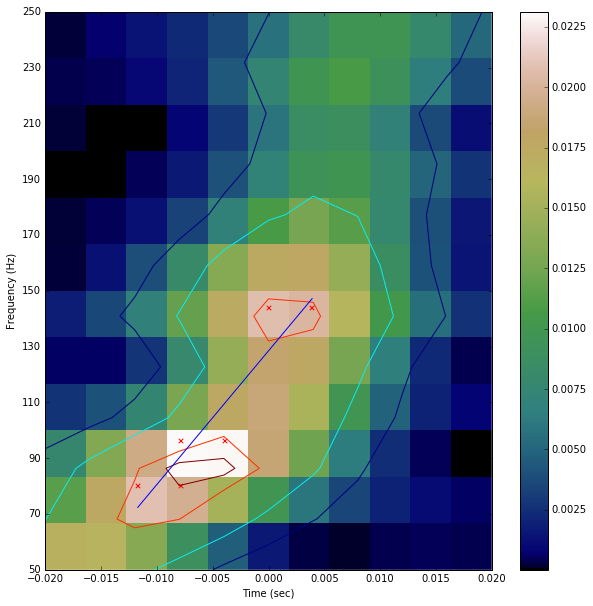

In [12]:
"""This program takes LIGO data and analyzes a specific range.  From the LIGO spectrogram data, the program takes the time and frequency dependencies,
plots a particular region of the spectrogram along with different contour levels.  Data points on the plot represent frequency values that fall within
the 85% contour level.  The line through the points represent the best-fit slope of the frequencies.  From the weighted-average frequency and the best-fit
slope, the program calculates the chirp mass in solar mass units.  The program conveys the weighted-average frequency, the slope, and the chirp mass."""

%matplotlib inline

def g(x, m, b):     #Function/Formula for a line.
    return m*x + b

def M(f, f_dot):     #Function that calculates chirp mass according to solar mass.
    solar_mass = 1.989e30
    return (1./solar_mass)*((c**3.)/G)*((5./96.)*(pi**(-8./3.))*(f**(-11./3.))*f_dot)**(3./5.)

###################################################################################################
###################################################################################################

with open('ligo_freq_t.p', 'r') as f:     #Makes ligo data available to use in python
    spec_data = pickle.load(f)

times = spec_data['t']
freqs = spec_data['freqs']
spec_H1 = spec_data['spec_H1']

####################################################################################################

times_cent = times-np.median(times)     #Centers times around its median value, in this case, the median is 10.0.  Upon print, the range is from about -10 to 10.
tevent = 0.     #Central point of times data
deltat = .02     #Range I want to search in the times data

freqs_min_range, freqs_max_range = 50., 250.     #Range of frequencies wanted.
freqs_idx = np.where((freqs >= freqs_min_range)*(freqs < freqs_max_range))     #Chooses a specific region of frequency to analyze
t_idx = np.where((times_cent >= tevent-deltat)*(times_cent < tevent+deltat))     #Chooses region of time, centered around tevent, and gives indices of selected region

idx2d = np.meshgrid(freqs_idx, t_idx)     #A list that consists of two 2D numpy arrays
spec_img = spec_H1[idx2d].T     #Chooses specific region of spectrogram to plot, using values from idx2d

max_spec_H1 = spec_H1.max()     #Maximum value of spec_H1 for later use in contour levels
sig1, sig2, sig3, sig4 = .25*max_spec_H1, .5*max_spec_H1, .85*max_spec_H1, .95*max_spec_H1     #Contour levels according to the maximum of spec_H1
contour_levels = [sig1, sig2, sig3, sig4]
extent = [-deltat, deltat, freqs_min_range, freqs_max_range]

idx85 = np.where(spec_H1 >= sig3)     #Indices of values within the 85% contour range.
f85 = freqs[idx85[0]]     #Frequencies that fall within the 85% contour category.
t85 = times_cent[idx85[1]]     #Times that fall within 85% contour category.
f = np.average(f85, weights=(spec_H1[idx85])**2)     #Frequency.

coeffs, cov = curve_fit(g, times_cent[idx85[1]], f85, p0=[4700., 0])     #Curve fitting to find the best-fit slope to the frequency and time values within the 85% contour.
f_dot = coeffs[0]     #Best-fit slope
b_best = coeffs[1]     #Best-fit y-intercept
chirp_mass = M(f, f_dot)     #Calulated chirp mass

print("f = {:.3f}, f_dot = {:.3f}".format(f, f_dot))
print("M_scrpt = {:.3f} M_Sun".format(chirp_mass))

fig, ax = plt.subplots(figsize = (10, 10))

plt.scatter(t85, f85, marker='x', c='r')     #Plots points that fall in the 85% contour regime.
plt.plot(t85, g(t85, f_dot, b_best))     #Plots best-fit slope line.

im_ax = plt.imshow(spec_img, extent=extent, cmap=plt.cm.gist_earth, aspect='auto', interpolation='none', origin='lower')     #Plots numpy array as image
CS = plt.contour(spec_img, linestyles=['-','-','-'], levels=contour_levels, extent=extent)     #Overlays contours onto 
fig.colorbar(im_ax)     #Adds color bar next to plot, for reference

plt.xlim(-deltat, deltat)
plt.ylim(freqs_min_range, freqs_max_range)
plt.yticks(np.arange(freqs_min_range, freqs_max_range+1, 20))

plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

plt.show()